In [61]:
import unstructured.partition.pdf as pdf
import inspect 
import os 
from PIL import Image
from pix2tex.cli import LatexOCR


In [5]:
from pathlib import Path

root = Path("data")
children = list(root.iterdir())
course_dirs = list(
    filter(
        lambda x: x.is_dir() and x.name not in [".git", ".DS_Store"],
        children,
    )
)
course_names = list(map(lambda x: x.name, course_dirs))
# course_names

In [53]:
data_path = "/home/reaganjlee/Berkeley-CS-QA-Dataset/data/"
course_path = "cs189/renamed_exams"
full_dir_path = data_path + course_path
base_name = "cs189_fall2015_final_blank"
# file_path = "cs189_fall2015_final_solution.pdf"

# Probably not that helpful as file structure gets more complex
def get_file_name(ending="", base_name=base_name):
    return f"{base_name}{ending}"

def get_pdf_path():
    return os.path.join(data_path, course_path, base_name) + ".pdf"
    

# def get_full_path(file_path=file_path, full_dir_path=full_dir_path):
#     return os.path.join(full_dir_path, file_path)

# print(get_full_path())
# print(get_full_path(""))


In [90]:
from datetime import datetime

def generate_folder_name(dataset_name):
    """
    Generates a folder name with the format: [DatasetName]_[YYYYMMDD]_[HHMMSS]

    :param dataset_name: The name of the dataset
    :return: A string representing the folder name
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"{dataset_name}_{timestamp}"
    return folder_name

def get_date():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

# Example usage
# exam_folder_name = generate_folder_name(get_file_name())
# print(exam_folder_name)


In [55]:
def make_tmp_folder():
    folder_path = data_path + "tmp/" + base_name
    print(f"folder_path: {folder_path}")
    # if not os.path.exists(folder_path) and os.path.isdir(folder_path):
    #     print(f"Making directory at {folder_path}")
    os.makedirs(folder_path, exist_ok=True)

def get_tmp_folder() -> str:
    return data_path + "tmp/" + base_name
make_tmp_folder()
    

folder_path: /home/reaganjlee/Berkeley-CS-QA-Dataset/data/tmp/cs189_fall2015_final_blank


In [98]:
partitioned_elements = pdf.partition_pdf(
    get_pdf_path(),
    # get_file_name(".pdf", "test"),
    include_page_breaks=True,
    strategy="hi_res",
    infer_table_structure=True,
    extract_images_in_pdf=True,
    output_type="dict",
    image_output_dir_path="testpdf_images",
)

In [99]:
len(partitioned_elements)

195

In [100]:
element = partitioned_elements[5]
print(element.metadata.coordinates.to_dict())
print(element.metadata.coordinates.system)
print(element.metadata.coordinates.system.orientation)
print(element.metadata.coordinates.system.width)
print(element.metadata.coordinates.system.height)


{'points': ((181.51388888888889, 442.6733333333336), (181.51388888888889, 509.34808349609375), (1539.998510888888, 509.34808349609375), (1539.998510888888, 442.6733333333336)), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}
Orientation.SCREEN
1700
2200


In [128]:
import fitz  # PyMuPDF

def convert_pdf_to_jpg_with_quad(indicies, partitioned_elements, pdf_path, output_dir, debug=False):
    """
    Convert a PDF to JPG after cropping with given quadrilateral points, scaling them to fit the PDF page dimensions.
    :param pdf_path: Path to the PDF file.
    :param quad_points: A list of 4 tuples, each representing the corners of the quadrilateral.
    :param output_path: Path to save the output JPG file.
    :param pixel_sys_width: Width of the original pixel-based system.
    :param pixel_sys_height: Height of the original pixel-based system.
    """
    doc = fitz.open(pdf_path)
    page = doc.load_page(0)
    pdf_width, pdf_height = page.rect.width, page.rect.height
    # assert isinstance(elements, list)
    if isinstance(indicies, int):
        indicies = [indicies]

    output_dir = output_dir + "/img"
    os.makedirs(output_dir)

    for i in indicies:
        element = partitioned_elements[i]
        if debug: 
            print(f"index {i} has element {element}")
            
        if element.metadata.coordinates is None: 
            continue
        quad_points = element.metadata.coordinates.points
        pixel_sys_width = element.metadata.coordinates.system.width
        pixel_sys_height = element.metadata.coordinates.system.height
        pdf_page_num = element.metadata.page_number

        doc = fitz.open(pdf_path)
        page = doc.load_page(pdf_page_num-1)
    
        if debug:
            print("beginning page cropbox: ", page.cropbox)
            print(f"pdf_width: {pdf_width}")
            print(f"pdf_height: {pdf_height}")

        # Calculate scaling factors
        scale_x = pdf_width / pixel_sys_width 
        scale_y = pdf_height / pixel_sys_height

        # Transform and scale the coordinates
        transformed_quad_points = []
        for x, y in quad_points:
            x_scaled = x * scale_x
            y_scaled = y * scale_y

            # Consider leaving this to raise if out of bounds 
            x_scaled = min(max(x_scaled, 0), pdf_width)
            y_scaled = min(max(y_scaled, 0), pdf_height)

            transformed_quad_points.append((x_scaled, y_scaled))


        # Convert quadrilateral into a rectangle for cropping (minimal bounding box)
        rect = fitz.Rect(fitz.Point(*transformed_quad_points[0]), fitz.Point(*transformed_quad_points[2]))

        if debug:
            print("original quad_points", quad_points)
            print("transformed_quad_points", transformed_quad_points)
            print("pdf dimensions", pdf_width, pdf_height)
            print("after page cropbox: ", page.cropbox)
            print("after page mediabox: ", page.mediabox)
            print("rect is: ", rect)

        # Crop the page
        page.set_cropbox(rect)

        zoom_x = 2.0  # horizontal zoom
        zoom_y = 2.0  # vertical zoom
        mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension
        pix = page.get_pixmap(matrix=mat)  # use 'mat' instead of the identity matrix

        # Save the image as JPG
        pix.save(f"{output_dir}/{i}.jpg")

        # Close the document
        doc.close()


# Example usage
# element = [partitioned_elements[21]]
indicies = range(27,55)
pdf_path = get_pdf_path() # get_file_name(".pdf")
output_dir = get_tmp_folder() + "_" + get_date() 
print(f"pdf path is {get_pdf_path()}")
print(f"output path is: {output_dir}")

convert_pdf_to_jpg_with_quad(indicies, partitioned_elements, pdf_path, output_dir)

pdf path is /home/reaganjlee/Berkeley-CS-QA-Dataset/data/cs189/renamed_exams/cs189_fall2015_final_blank.pdf
output path is: /home/reaganjlee/Berkeley-CS-QA-Dataset/data/tmp/cs189_fall2015_final_blank_20231222_185718


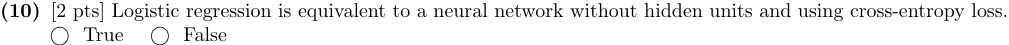

\mathrm{{\bf(10)}}\underbrace{\mathrm{[2)}^{\mathrm{Toglaslelercegonisenteguntiont~to~aneurahtanionithont~theang~croenropy~loasmentrogleantis~sing~crosenropy~tease}}


In [129]:
blah = "/home/reaganjlee/Berkeley-CS-QA-Dataset/data/tmp/cs189_fall2015_final_blank_20231222_183348/28.jpg"
img = Image.open(blah)
display(img)
model = LatexOCR()
result = model(img)
print(result)

In [130]:
import json
def convert_jpg_to_latex(io_dir):
    print(f"Converting jpgs to latex in io_dir {io_dir}")
    output = []
    model = LatexOCR()
    img_dir = io_dir + "/img" # Images  
    for img_file in os.listdir(img_dir):
        # if not isinstance(img, Image)
        # assuming each file is a jpg for now
        if not img_file.endswith('.jpg'):
            print("Warning, there's a file that's not a jpg in the img dir")
            continue
        img = Image.open(f"{img_dir}/{img_file}")
        output.append(model(img))

    with open(f'{io_dir}/latex_out.json', 'w') as file:
        json.dump(output, file)
    print(f"Saved latex output to {f'{io_dir}/latex_out.json'}")
# TODO: get a pandas df to put these all together 
convert_jpg_to_latex(output_dir)

Saved latex output to /home/reaganjlee/Berkeley-CS-QA-Dataset/data/tmp/cs189_fall2015_final_blank_20231222_185718/latex_out.json


In [80]:
from IPython.display import display, Latex
print(result)
dis = display(Latex(f'${result}$'))
dis

\begin{array}{l l}{{(4)}}&{{[2{\mathrm{~ptsl~Convolutional~networks~are~rotation~invariant}}.}}\\ {{{\mathrm{~CO~True}}}}&{{\mathrm{~Co~False}}}\end{array}


<IPython.core.display.Latex object>